In [275]:
# from flask import Flask, render_template, request, send_file
from PIL import Image, ImageDraw, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
import warnings
import concurrent.futures
warnings.filterwarnings("ignore")

In [276]:
# CONSTANTS
EDGE_POINTS = 200
STRING_OPACITY = 60 # 0-255
INVERTED = False
CONTRAST = 0.9 # 0-127 
BRIGHTNESS = 0.7
N_LINES = 2000
CHANGE_WEIGHT = 1 # How much the algo will value new pixel changes
IMAGE_DIM = 400
NUM_THREADS = 4

In [277]:
g_thread_pool = concurrent.futures.ThreadPoolExecutor(max_workers=NUM_THREADS)
g_image_path = "./images/obama.png" # Change to Relative Path or some hardcoded path on the repo

In [278]:
image = Image.open(g_image_path)
size = min(image.size)
image = ImageOps.fit(image, (size, size), Image.ANTIALIAS)
width, height = image.size

# Create a circular mask
mask = Image.new('L', image.size, 0)
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size, size), fill=255)

# Apply circular mask to the image
circular_image = Image.new('RGB', (width, height))
circular_image.paste(image, mask=mask)

# Save or serve the resulting image
output = BytesIO()
output_path = "./out_images/"+ g_image_path[9:]
circular_image.save(output, format='PNG')
circular_image.save(output_path, format='PNG')

In [279]:
def image_cleanup(img):

    # Black and White
    output_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur the image
    # output_image = cv2.GaussianBlur(output_img, (5, 5), 0)
    
    # Scale the image to 400x400 pixels
    output_img = cv2.resize(output_img, (IMAGE_DIM, IMAGE_DIM))
    
    #Invert the Image
    if INVERTED:
        output_img = cv2.bitwise_not(output_img)

    output_img = cv2.addWeighted(output_img, CONTRAST, output_img, 0, BRIGHTNESS)
    return output_img

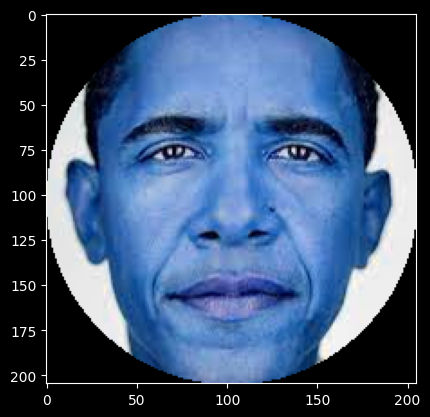

In [280]:
img = cv2.imread(output_path)
plt.imshow(img)

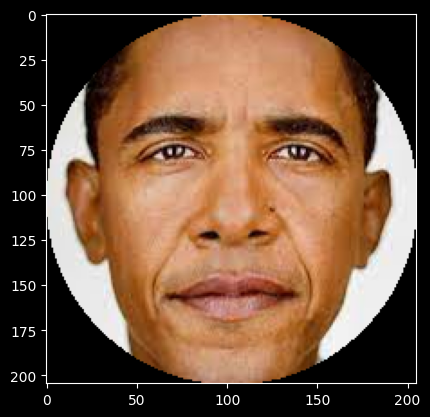

In [281]:
img_RGB = img[:,:,::-1]
plt.imshow(img_RGB)

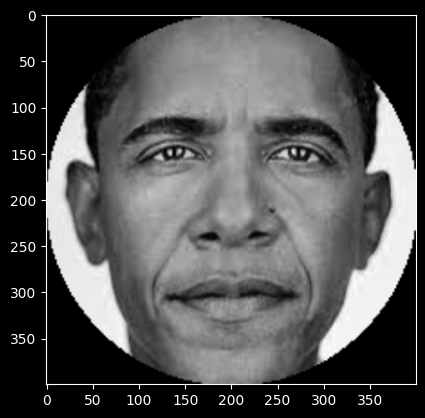

In [282]:
final_img = image_cleanup(img_RGB)
plt.imshow(final_img,'gray')

In [283]:
def edge_points(img, n):
    points = []
    height, width = img.shape
    # Define circle parameters (adjust these based on your image size)
    center_x = width // 2
    center_y = height // 2
    radius = min(center_x, center_y) - 1  # Ensure the circle is within the image bounds

    # Sample points along the circumference
    theta = np.linspace(0, 2 * np.pi, n)
    edge_points_x = np.uint16(center_x + radius * np.cos(theta))
    edge_points_y = np.uint16(center_y + radius * np.sin(theta))
    edge_points_x = edge_points_x.astype(np.int64)
    edge_points_y = edge_points_y.astype(np.int64)
    return edge_points_x, edge_points_y

def draw_lines(edge_x, edge_y):
    for i in range(0,EDGE_POINTS):
        for j in range(i,EDGE_POINTS):
            xs = [edge_x[i],edge_x[j]]
            ys = [edge_y[i],edge_y[j]]
            plt.plot(xs, ys,color='black',lw = 0.1)

edge_x, edge_y = edge_points(final_img, EDGE_POINTS)
# plt.figure(figsize=(5,5))
# plt.plot(edge_x, edge_y,'o')
# draw_lines(edge_x, edge_y)

In [284]:
def bresenham(x1, y1, x2, y2, swap=False, neg_y=False):
    if y2 < y1 and not neg_y:
        return bresenham(x1, y1, x2, y2, swap=swap, neg_y=True)
    if x2 < x1:
        return bresenham(x2, y2, x1, y1, swap=swap)[::-1]
    line = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    if dy > dx:
        return bresenham(y1, x1, y2, x2, swap=True)
    P = 2 * dy - dx
    while x <= x2:
        if swap:
            line.append((y, x))
        else:
            line.append((x, y))
        x += 1
        if P < 0:
            P = P + 2 * dy
        else:
            P = P + 2 * dy - 2 * dx
            if neg_y:
                y -= 1
            else:
                y += 1
    return line

# bresenham(29,97,196,1)

In [285]:
def create_database(edge_x,edge_y):
    line_dict = dict()
    for i in range(0,EDGE_POINTS): # for every edge point
        for j in range(i+1,EDGE_POINTS): # go to all the others,  
            # Calculate intermediate points with bresenham
            points = [(edge_x[i],edge_y[i]), (edge_x[j],edge_y[j])]  
            # points.sort(key=lambda x: x[0]) # NOTE: Do we really need to sort?
            x1, y1 = points[0][0], points[0][1]
            x2, y2 = points[1][0], points[1][1]
            if not f"{x1},{y1}" in line_dict: line_dict[f"{x1},{y1}"] = dict()
            if not f"{x2},{y2}" in line_dict: line_dict[f"{x2},{y2}"] = dict()
            
            tmp = bresenham(x1,y1,x2,y2)
            line_dict[f"{x1},{y1}"][f"{x2},{y2}"] = tmp
            line_dict[f"{x2},{y2}"][f"{x1},{y1}"] = tmp
            # line_dict[f"{x1},{y1} {x2},{y2}"] = bresenham(x1,y1,x2,y2) # Add to dictionary
    return line_dict

line_dict = create_database(edge_x,edge_y)
# line_dict

In [286]:
def error(img,canvas,change):
    return np.sum(np.sum(abs(img-canvas))) - change

def try_line(points,current_canvas,img):
    change = 0
    temp_canvas = np.copy(current_canvas) # NOTE: Find better approach than copying

    for x,y in points:
        # NOTE: Would be nice if SIMD can be incorporated somehow
        prev_value = temp_canvas[x,y]
        mask = (255-(prev_value + STRING_OPACITY))>>31
        temp_canvas[x,y] = ((~mask&0xFF) & (STRING_OPACITY + prev_value)) | (mask & 0xFF) 
        change += temp_canvas[x,y] - prev_value

    return error(img,temp_canvas,change*CHANGE_WEIGHT), temp_canvas

In [287]:
def get_new_canvas(start, key, value, current_canvas, img):
    current_error, temp_canvas = try_line(line_dict[start][key], current_canvas,img)
    return current_error,temp_canvas,key

In [288]:
def pick_next_point(start,current_canvas, img, line_dict):
    best_line = random.choice(list(line_dict[start].keys())) # Initialize to random edge point
    best_error = try_line(line_dict[start][best_line],current_canvas,img)[0]
    new_canvas = current_canvas
    

    for future in concurrent.futures.as_completed([g_thread_pool.submit(get_new_canvas,start, key, value, current_canvas,img) for key,value in line_dict[start].items()]):
        current_error, temp_canvas, key = future.result()
        if current_error < best_error:
            best_error = current_error
            best_line = key
            new_canvas = temp_canvas
    # concurrent.futures.wait(fs, timeout=None, return_when=ALL_COMPLETED)


        #for key, value in line_dict[start].items():

        # current_error, temp_canvas = try_line(line_dict[start][key], current_canvas,img)


    return best_line, new_canvas

In [289]:
def sim(n, img):
    start = next(iter(line_dict)) # Picks the first element from the line_dict
    start_x, start_y = start.split(',') 
    xs = [int(start_x)]
    ys = [int(start_y)]
    current_canvas = np.zeros_like(img)
    for i in range(n):
        # start_time = time.time() # PERF CHECK
        point, new_canvas = pick_next_point(start, current_canvas, img, line_dict)
        start = point
        x, y = point.split(',')
        xs.append(int(x))
        ys.append(int(y))
        current_canvas = new_canvas
        # print("--- %s seconds ---" % (time.time() - start_time)) # PERF CHECK

    return current_canvas,np.array(xs),np.array(ys)

In [290]:
image = np.array(np.array(final_img).tolist())
finished_canvas, xs,ys = sim(N_LINES, image)
#plt.figure(figsize=(7,7))
# edge_x, edge_y = edge_points(img3, 100)
# plt.plot(edge_x, edge_y,'.',alpha = 0.2)
# plt.plot(xs,ys,alpha = 0.5,color='black')

In [291]:
# print(list(zip(xs,ys)))

In [292]:
# plt.figure(figsize=(7,7))
# plt.imshow(finished_canvas, 'gray')
# plt.plot(xs,ys,'black', lw = 0.2)
# plt.imshow(img3)

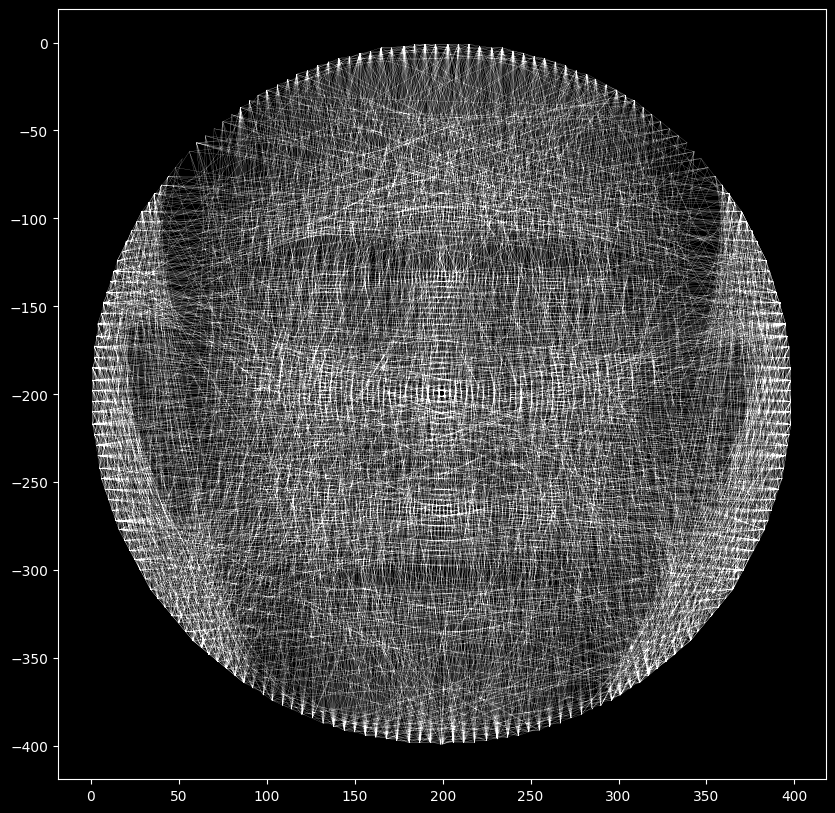

In [299]:
plt.figure(figsize=(10,10))
plt.style.use('dark_background')
plt.plot(ys,-xs,'white',lw=0.1,alpha=1)
plt.gca().set_aspect('equal')

In [294]:
g_thread_pool.shutdown(wait=True)